In [ ]:
!pip install -q git+https://github.com/rwightman/pytorch-image-models.git
# !pip install wandb --upgrade
!pip install -q jupyterlab-git --upgrade
!pip install -q nbdev

In [ ]:
!pip list | grep "torch\|cuda\|fast"

cupy-cuda110                   8.6.0
fastai                         2.3.0
fastavro                       1.4.0
fastcore                       1.3.19
fastprogress                   1.0.0
fastrelease                    0.1.11
fastrlock                      0.6
fasttext                       0.9.2
jaxlib                         0.1.64+cuda110
nnabla-ext-cuda110             1.19.0
pycuda                         2021.1
pyfasttext                     0.4.6
pytorch-ignite                 0.4.4
pytorch-lightning              1.2.8
torch                          1.7.0
torchaudio                     0.7.0a0+ac17b64
torchmetrics                   0.2.0
torchtext                      0.8.0a0+cd6902d
torchvision                    0.8.1


In [ ]:
import pandas as pd
import timm
from timm import *

from fastai.vision.all import *
from fastai.vision.learner import _update_first_layer
from fastai.callback.wandb import *
from nbdev.showdoc import show_doc

In [ ]:
df_study_lvl = pd.read_csv("../input/siim-covid19-detection/train_study_level.csv")
df_study_lvl.rename({'id':'study_id',
                      'Negative for Pneumonia':'negative',
                      'Typical Appearance':'typical',
                      'Indeterminate Appearance':'indeterminate',
                      'Atypical Appearance':'atypical'}, axis=1, inplace=True)

df_image_lvl = pd.read_csv('/kaggle/input/siim-covid19-detection/train_image_level.csv')
df_image_lvl['study_id'] = df_image_lvl['StudyInstanceUID'].apply(lambda idx: idx+"_study")

df_annotations = df_image_lvl.merge(df_study_lvl, on='study_id', how='outer')
df_annotations.head(3)

,id,boxes,label,StudyInstanceUID,study_id,negative,typical,indeterminate,atypical
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]",opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472,5776db0cec75,5776db0cec75_study,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,ff0879eb20ed_study,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867.79767, 'height': 999.78214}, {'x': 1792.69064, 'y': 402.5525, 'width': 617.02734, 'height': 1204.358}]",opacity 1 677.42216 197.97662 1545.21983 1197.75876 opacity 1 1792.69064 402.5525 2409.71798 1606.9105,9d514ce429a7,9d514ce429a7_study,0,1,0,0


In [ ]:
PATH = '../input/siim-covid19-images-metadata-256-512-768/images_metadata_256_512_768/train_512x512'

df_annotations['image_path'] = df_annotations['id'].map(lambda x:os.path.join(PATH,
                                                                              str(x)+'.png'))

In [ ]:
label_names = ['negative','typical','indeterminate','atypical']

def get_labels(row):
    labels_str = ''
    for key in label_names:
        if row[key]==1:
             labels_str = labels_str+' '+key if labels_str else key
    return labels_str

df_annotations['labels'] = df_annotations[label_names].apply(get_labels, axis=1)

In [ ]:
df_annotations.sample(4)

,id,boxes,label,StudyInstanceUID,study_id,negative,typical,indeterminate,atypical,image_path,labels
3642,8dc3ee79f389_image,NaN,none 1 0 0 1 1,773f243da328,773f243da328_study,1,0,0,0,../input/siim-covid19-images-metadata-256-512-768/images_metadata_256_512_768/train_512x512/8dc3ee79f389_image.png,negative
1825,4507b1846ced_image,NaN,none 1 0 0 1 1,6fcd121e2158,6fcd121e2158_study,1,0,0,0,../input/siim-covid19-images-metadata-256-512-768/images_metadata_256_512_768/train_512x512/4507b1846ced_image.png,negative
5625,e0309637bb7d_image,"[{'x': 868.10591, 'y': 337.75964, 'width': 448.71686, 'height': 466.31363}, {'x': 1964.96945, 'y': 557.71891, 'width': 425.25464, 'height': 991.28314}, {'x': 847.57637, 'y': 1249.8574, 'width': 475.112, 'height': 683.34009}]",opacity 1 868.10591 337.75964 1316.82277 804.07327 opacity 1 1964.96945 557.71891 2390.22409 1549.00205 opacity 1 847.57637 1249.8574 1322.68837 1933.19749,8f3a2c63b390,8f3a2c63b390_study,0,1,0,0,../input/siim-covid19-images-metadata-256-512-768/images_metadata_256_512_768/train_512x512/e0309637bb7d_image.png,typical
2478,5ec4ddd371c1_image,"[{'x': 682.4939, 'y': 242.60844, 'width': 659.99036, 'height': 845.74106}, {'x': 1520.83781, 'y': 314.11424, 'width': 638.62097, 'height': 929.57547}]",opacity 1 682.4939 242.60844 1342.4842600000002 1088.3495 opacity 1 1520.83781 314.11424 2159.45878 1243.68971,fd657558f339,fd657558f339_study,0,0,0,1,../input/siim-covid19-images-metadata-256-512-768/images_metadata_256_512_768/train_512x512/5ec4ddd371c1_image.png,atypical


In [ ]:
# from pprint import pprint
# model_names = timm.list_models()
# pprint(model_names)

In [ ]:
timm.list_models('*efficientnet*')

['eca_efficientnet_b0',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t',
 'efficientnetv2_s',
 'efficientnetv2_xl',
 'gc_efficientnet_b0',
 'gc_efficientnetv2_rw_t',
 'tf_efficientnet_b0',
 'tf_efficientnet_b0_ap',
 'tf_efficientnet_b0_ns',
 'tf_efficientnet_b1',
 'tf_efficientnet_b1_ap',
 'tf_efficientn

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if device=='GPU':
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

In [ ]:
class Config:
    seed_val = 111
    seed_everything(seed_val)
    fold_num = 0
    job = 1
    num_classes = 4
    input_dims = 512
    model_arch = 'tf_efficientnetv2_m_in21ft1k'
    batch_size = 18
    num_workers = 0
    kfold = 5
    loss_func = nn.BCEWithLogitsLoss() # CrossEntropyLossFlat() or LabelSmoothingCrossEntropyFlat() for multi-class
    metrics = [accuracy_multi, RocAucMulti(average='macro'), F1ScoreMulti(average='macro')]
    job_name = f'{model_arch}_fold{fold_num}_job{job}'
    print("Job Name:", job_name)

    wandb_project = 'SIIM_classifier_public'
    wandb_run_name = job_name
    
    if device=='GPU':
        fp16 = True
    else:
        fp16 = False
    
cfg = Config()

Job Name: tf_efficientnetv2_m_in21ft1k_fold0_job1


In [ ]:
# Converting global config class object to a dictionary to log using Wandb
config_dict = dict(vars(Config))
config_dict = {k:(v if type(v)==int else str(v)) for (k,v) in config_dict.items() if '__' not in k}
config_dict

{'seed_val': 111,
 'fold_num': 0,
 'job': 1,
 'num_classes': 4,
 'input_dims': 512,
 'model_arch': 'tf_efficientnetv2_m_in21ft1k',
 'batch_size': 18,
 'num_workers': 0,
 'kfold': 5,
 'loss_func': 'BCEWithLogitsLoss()',
 'metrics': '[<function accuracy_multi at 0x7f024c039a70>, <fastai.metrics.AccumMetric object at 0x7f031d0d2a90>, <fastai.metrics.AccumMetric object at 0x7f031d0d23d0>]',
 'job_name': 'tf_efficientnetv2_m_in21ft1k_fold0_job1',
 'wandb_project': 'SIIM_classifier_public',
 'wandb_run_name': 'tf_efficientnetv2_m_in21ft1k_fold0_job1',
 'fp16': 'True'}

In [ ]:
from sklearn.model_selection import GroupKFold, train_test_split

df_annotations['fold'] = -1
grp_kfold  = GroupKFold(n_splits = cfg.kfold)
for fold, (train_index, val_index) in enumerate(grp_kfold.split(df_annotations,
                                                              groups=df_annotations.study_id.tolist())):
    df_annotations.loc[val_index, 'fold'] = fold
df_annotations.sample(3)

,id,boxes,label,StudyInstanceUID,study_id,negative,typical,indeterminate,atypical,image_path,labels,fold
1394,341787fb81c7_image,NaN,none 1 0 0 1 1,55fb3303c057,55fb3303c057_study,1,0,0,0,../input/siim-covid19-images-metadata-256-512-768/images_metadata_256_512_768/train_512x512/341787fb81c7_image.png,negative,2
3619,8d025358b1fd_image,"[{'x': 294.57009, 'y': 1397.40516, 'width': 917.62064, 'height': 545.32886}, {'x': 1484.85511, 'y': 1365.94388, 'width': 1043.46582, 'height': 508.62402}]",opacity 1 294.57009 1397.40516 1212.19073 1942.7340199999999 opacity 1 1484.85511 1365.94388 2528.32093 1874.5679,6c7422f3cd88,6c7422f3cd88_study,0,0,1,0,../input/siim-covid19-images-metadata-256-512-768/images_metadata_256_512_768/train_512x512/8d025358b1fd_image.png,indeterminate,1
377,0cb52238e1e2_image,"[{'x': 1907.90811, 'y': 938.23462, 'width': 356.8368, 'height': 482.96002}, {'x': 615.91297, 'y': 1116.65296, 'width': 412.20801, 'height': 396.82703}]",opacity 1 1907.90811 938.23462 2264.74491 1421.19464 opacity 1 615.91297 1116.65296 1028.12098 1513.4799899999998,89cc008ddabf,89cc008ddabf_study,0,0,1,0,../input/siim-covid19-images-metadata-256-512-768/images_metadata_256_512_768/train_512x512/0cb52238e1e2_image.png,indeterminate,0


In [ ]:
import albumentations as A

# Source: https://forums.fast.ai/t/albumentation-transformations-for-train-and-test-dataset/82642
class AlbumentationsTransform(RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    
def get_train_aug(): 
    return A.Compose([
#         A.RandomResizedCrop(cfg.input_dims,cfg.input_dims), 
        A.Resize(cfg.input_dims, cfg.input_dims, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=10, p=0.5),
        A.IAAPerspective(scale=(0.02, 0.04), p=0.5),
        A.RandomBrightnessContrast(0.1, 0.1, p=0.5),
        A.OneOf([A.CLAHE(),
                 A.HueSaturationValue(0.2, 0.2, 0.2, p=0.5)
                ],p=0.4),
        A.OneOf([A.CoarseDropout(),
                 A.Cutout()], p=0.5)
    ])

def get_valid_aug():
    return A.Compose([A.Resize(cfg.input_dims, cfg.input_dims, p=1.0)], p=1.0)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

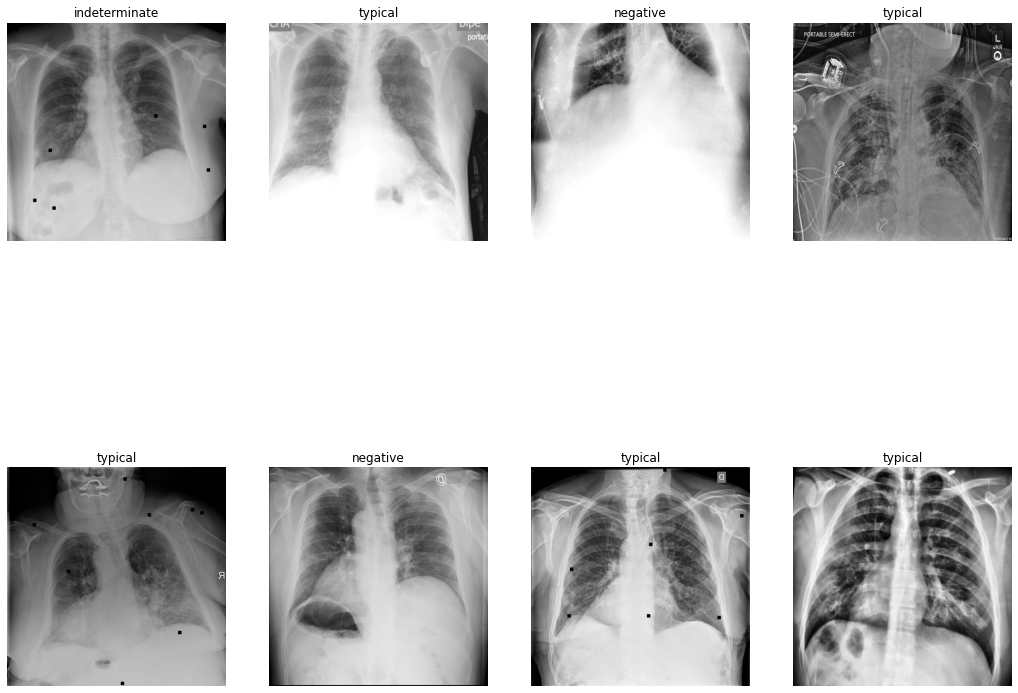

In [ ]:
val_indices = list(df_annotations[df_annotations['fold'] == cfg.fold_num].image_path.unique())

data_block = DataBlock(blocks=(ImageBlock, MultiCategoryBlock(vocab=['negative', 'typical', 'indeterminate', 'atypical'],
                                                              encoded=True)),
                   splitter=MaskSplitter(list(df_annotations['fold'] == fold)),
                   get_x=ColReader('image_path'),
                   get_y=ColReader(['negative', 'typical', 'indeterminate', 'atypical']),
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)

dls = data_block.dataloaders(df_annotations,
                            bs=cfg.batch_size,
                            num_workers=cfg.num_workers)

dls.show_batch(figsize=(18,15), max_n=8, nrows=2)

In [ ]:
doc(create_body)

In [ ]:
doc(create_model)

In [ ]:
doc(create_body)

In [ ]:
# Adapted from https://walkwithfastai.com/vision.external.timm

from fastai.vision.learner import _add_norm

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3,
                      init=nn.init.kaiming_normal_, custom_head=None,
                      concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children()))
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, fp16=False, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    
    # Enable Mixed Precision Training
    if fp16: learn.to_non_native_fp16()
#     if fp16: learn.to_fp16(growth_factor=1.0)
    return learn

In [ ]:
doc(WandbCallback)

In [ ]:
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

# I have saved my API token with "wandb_api" as the Label. 
# If you use some other Label make sure to change the same below. 
wandb_api = user_secrets.get_secret("wandb_key") 

wandb.login(key=wandb_api)

wandb.init(project=cfg.wandb_project, name=cfg.wandb_run_name, config=config_dict)

In [ ]:
cbs = [
    WandbCallback(log='gradients',
                  log_preds=True,
                  log_model=True,
                  log_dataset=False,
                  dataset_name=None,
                  valid_dl=None,
                  n_preds=36,
                  seed=cfg.seed_val,
                  reorder=True),
    
    SaveModelCallback(monitor='valid_loss',
                      comp=None,
                      min_delta=0.0,
                      fname=cfg.job_name,
                      every_epoch=False,
                      with_opt=False,
                      reset_on_fit=True)
      ]

In [ ]:
learn = timm_learner(dls,
                     cfg.model_arch,
                     loss_func=cfg.loss_func,
                     pretrained=True,
                     opt_func=ranger,
                     splitter=default_split,
                     fp16=cfg.fp16,
                     metrics=cfg.metrics,
                     cbs=cbs)
# learn.summary()

In [ ]:
frozen_params = filter(lambda p: not p.requires_grad, learn.model.parameters())
unfrozen_params = filter(lambda p: p.requires_grad, learn.model.parameters())

print(f'Total Parameters: {sum([np.prod(p.size()) for p in learn.model.parameters()])}')
print(f'Frozen Parameters: {sum([np.prod(p.size()) for p in frozen_params])}')
print(f'Unfrozen Parameters: {sum([np.prod(p.size()) for p in unfrozen_params])}')

Total Parameters: 54177268
Frozen Parameters: 52566324
Unfrozen Parameters: 1610944


In [ ]:
# learn.unfreeze()
learn.fit_one_cycle(10, 5e-3)

epoch,train_loss,valid_loss,accuracy_multi,roc_auc_score,f1_score,time
0,0.771072,0.556477,0.746643,0.666381,0.408391,06:33
1,0.512936,0.450877,0.811611,0.693224,0.345643,05:48
2,0.466667,0.431522,0.808847,0.722083,0.311011,05:50
3,0.427300,0.410695,0.825829,0.743289,0.349625,05:57
4,0.416122,0.402290,0.836295,0.757658,0.367921,06:00
5,0.393783,0.400867,0.833531,0.761915,0.373305,06:00
6,0.375754,0.392644,0.837480,0.770545,0.362707,06:02
7,0.372144,0.395684,0.834123,0.770259,0.346137,06:03
8,0.363753,0.393781,0.834123,0.773674,0.363061,06:01
9,0.352584,0.391808,0.838665,0.774620,0.367263,06:01


Better model found at epoch 0 with valid_loss value: 0.5564768314361572.
Better model found at epoch 1 with valid_loss value: 0.4508773982524872.
Better model found at epoch 2 with valid_loss value: 0.4315223693847656.
Better model found at epoch 3 with valid_loss value: 0.41069495677948.
Better model found at epoch 4 with valid_loss value: 0.40228956937789917.
Better model found at epoch 5 with valid_loss value: 0.4008668065071106.
Better model found at epoch 6 with valid_loss value: 0.392644464969635.
Better model found at epoch 9 with valid_loss value: 0.3918081820011139.


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(1e-7, 5e-5))

epoch,train_loss,valid_loss,accuracy_multi,roc_auc_score,f1_score,time
0,0.357773,0.393900,0.838073,0.773179,0.367106,15:11
1,0.359140,0.394335,0.835703,0.771336,0.362593,15:08


Better model found at epoch 0 with valid_loss value: 0.39389991760253906.


In [ ]:
# # Predict
image_paths = df_annotations[df_annotations.fold==0].image_path.tolist()
test_dl = learn.dls.test_dl(image_paths)
preds = nn.Sigmoid()(learn.get_preds(dl=test_dl)[0]).detach().cpu().numpy()

thr = 0.5
print("Predicted Before Threshold:\n", preds)
preds = np.where(preds>thr, 1, 0)

label_cols = ['negative', 'typical', 'indeterminate', 'atypical']
actual = df_annotations[df_annotations.fold==0][label_cols].to_numpy()

print("Actual Labels:\n", actual)
print("Predicted Labels:\n", preds)

Predicted Before Threshold:
 [[0.2120688  0.41264847 0.28110948 0.05964694]
 [0.02387084 0.7126323  0.20785716 0.02025469]
 [0.00959645 0.9339146  0.04443143 0.0057974 ]
 ...
 [0.5325771  0.1336412  0.21076629 0.04769128]
 [0.5546212  0.1625129  0.17147702 0.02503542]
 [0.00586534 0.9449947  0.05623635 0.00316035]]
Actual Labels:
 [[1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 ...
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]]
Predicted Labels:
 [[0 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 ...
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]]


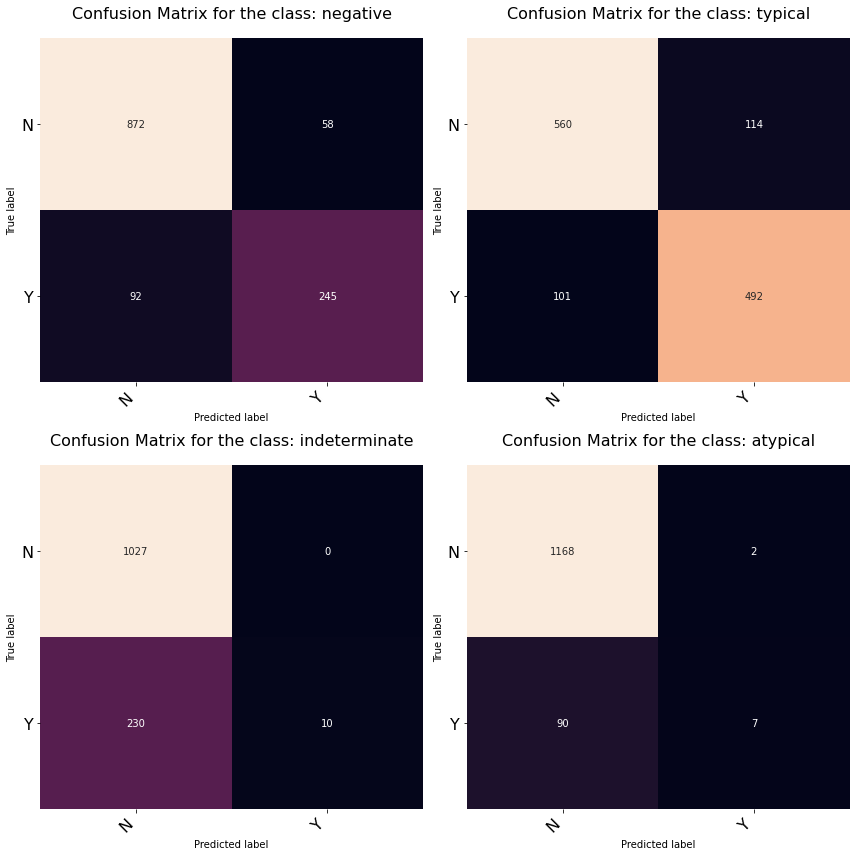

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

def plot_confusion_matrix(con_matrix, axes, label, class_names, fontsize=16):
    df = pd.DataFrame(con_matrix,
                         index=class_names,
                         columns=class_names
                        )
    heatmap = sns.heatmap(df, annot=True, fmt="d", cbar=False, ax=axes)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(f"Confusion Matrix for the class: {label}", fontsize=fontsize, pad=20)
    
con_matrices = multilabel_confusion_matrix(actual, preds)
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for axes, con_matrix, label in zip(ax.flatten(), con_matrices, label_cols):
    plot_confusion_matrix(con_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.savefig('con_matrix.png')
plt.show()